# Processing Notebook

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read csv

In [29]:
df: pd.DataFrame = pd.read_csv("neutron25_25.csv")
df.head()

,vx,vy,vz,sci_photons,xpos0,ypos0,photons0,xpos1,ypos1,photons1,xpos2,ypos2,photons2,xpos3,ypos3,photons3
0,-9.392740,8.17019,5.46909,28675,-25.0,-25.0,29,-25.0,25.0,60,25.0,-25.0,24,25.0,25.0,33
1,0.461883,2.81748,6.17655,30,-99.9,-99.9,-1,-99.9,-99.9,-1,-99.9,-99.9,-1,-99.9,-99.9,-1
2,-22.991100,-11.64610,-4.16570,70,-99.9,-99.9,-1,-99.9,-99.9,-1,-99.9,-99.9,-1,-99.9,-99.9,-1
3,-6.181520,10.41410,2.30438,0,-99.9,-99.9,-1,-99.9,-99.9,-1,-99.9,-99.9,-1,-99.9,-99.9,-1
4,20.558600,19.69940,7.24930,28167,-25.0,-25.0,16,-25.0,25.0,32,25.0,-25.0,29,25.0,25.0,138


## Make basic scatterplot to check

Text(0.5, 1.0, 'Scatterplot of event locations')

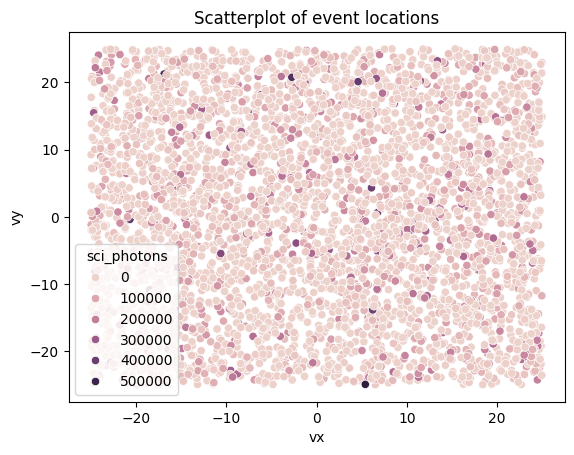

In [30]:
sns.scatterplot(data=df,x='vx',y='vy',hue="sci_photons")
plt.title("Scatterplot of event locations")

## Count instances of no photons being detected

In [31]:
tmp = np.zeros_like(df['photons0'],dtype=int)
nx = 2
ny = 2
n = nx * ny
for i in range(n):
    tmp += (df[f'photons{i}'] < 0)

NOPHOTONS = tmp == n

print("Number of rows with no detected photons:",sum(NOPHOTONS))
print("Number of rows with detectd photons:",sum(~NOPHOTONS))
print("Efficiency:",sum(~NOPHOTONS)/len(df["photons0"]))

Number of rows with no detected photons: 1150
Number of rows with detectd photons: 2847
Efficiency: 0.7122842131598699


## Dynamically determine which columns are right or left and up or down

In [32]:
left_dropnames = [] # Columns to drop to get left subset
right_dropnames = [] # Columns to drop to get right subset
up_dropnames = [] # Columns to drop to get up subset
down_dropnames = [] # Columns to drop to get down subset
nx = 2
ny = 2
num = 0
for i in range(nx):
    for j in range(ny):
        if i < (nx / 2):
            print("left:",num)
            right_dropnames.append(f"photons{num}")
            right_dropnames.append(f"ypos{num}")
            right_dropnames.append(f"xpos{num}")
        else:
            print("right",num)
            left_dropnames.append(f"photons{num}")
            left_dropnames.append(f"ypos{num}")
            left_dropnames.append(f"xpos{num}")

        if j < (ny / 2):
            print("down:",num)
            up_dropnames.append(f"photons{num}")
            up_dropnames.append(f"ypos{num}")
            up_dropnames.append(f"xpos{num}")
        else:
            print('up:',num)
            down_dropnames.append(f"photons{num}")
            down_dropnames.append(f"ypos{num}")
            down_dropnames.append(f"xpos{num}")

        df = df[df[f'photons{num}'] != -1]
        num += 1

left: 0
down: 0
left: 1
up: 1
right 2
down: 2
right 3
up: 3


In [33]:
left: pd.DataFrame = df.drop(left_dropnames,axis=1)
right: pd.DataFrame = df.drop(right_dropnames,axis=1)
up: pd.DataFrame = df.drop(up_dropnames,axis=1)
down: pd.DataFrame = df.drop(down_dropnames,axis=1)

In [34]:
n = nx * ny

left['total'] = np.zeros_like(left['vx']).astype(int)
right["total"] = np.zeros_like(right['vx']).astype(int)
up['total'] = np.zeros_like(up['vx']).astype(int)
down['total'] = np.zeros_like(down['vx']).astype(int)
df["total"] = np.zeros_like(df['vx']).astype(int)
for i in range(n):
    # LEFT AND RIGHT
    try:
        left['total'] = left['total'] + left[f"photons{i}"]
    except:
        pass
    try:
        right['total'] = right['total'] + right[f"photons{i}"]
    except:
        pass

    # UP AND DOWN
    try:
        up['total'] = up['total'] + up[f'photons{i}']
    except:
        pass
    try:
        down['total'] = down['total'] + down[f'photons{i}']
    except:
        pass

    df['total'] = df['total'] + df[f"photons{i}"]


Text(0.5, 0, 'vx')

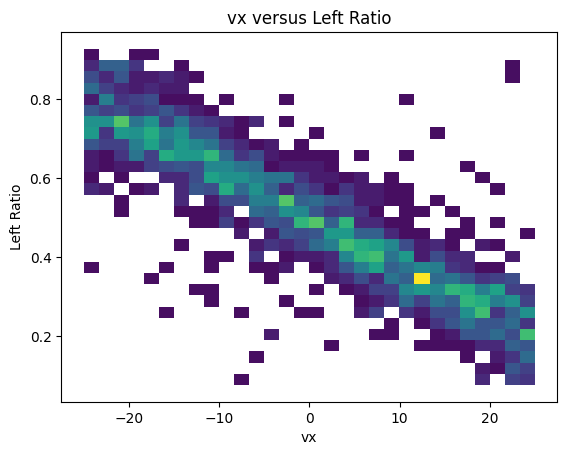

In [35]:
left_ratio = left['total']/df['total']
sns.histplot(x=df["vx"],y=left_ratio,cmap="viridis",bins=30)
plt.title("vx versus Left Ratio")
plt.ylabel("Left Ratio")
plt.xlabel("vx")

Text(0.5, 0, 'vx')

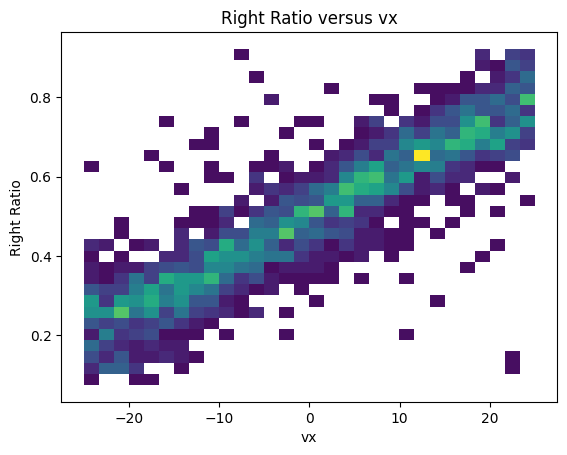

In [36]:
right_ratio = right['total']/df['total']
sns.histplot(x=df["vx"],y=right_ratio,cmap="viridis",bins=30)
plt.title("Right Ratio versus vx")
plt.ylabel("Right Ratio")
plt.xlabel("vx")

Text(0.5, 0, 'vy')

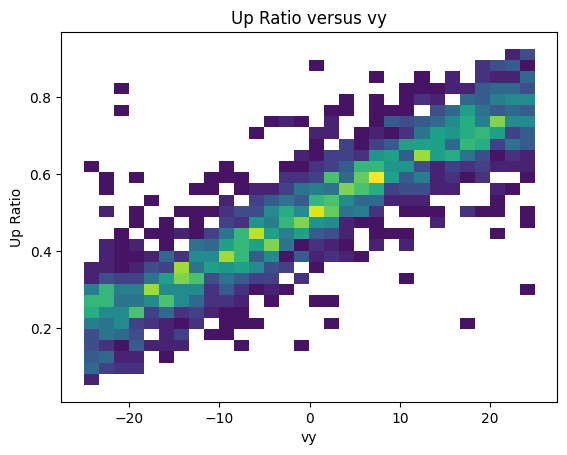

In [37]:
up_ratio = up['total']/df['total']
sns.histplot(x=df["vy"],y=up_ratio,cmap="viridis",bins=30)
plt.title("Up Ratio versus vy")
plt.ylabel("Up Ratio")
plt.xlabel("vy")

Text(0.5, 0, 'vy')

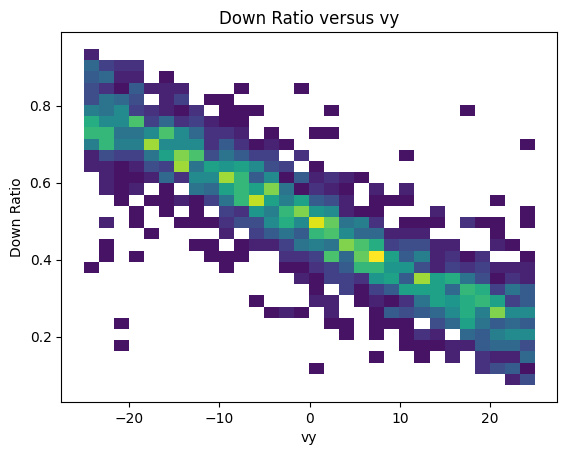

In [38]:
down_ratio = down['total']/df['total']
sns.histplot(x=df["vy"],y=down_ratio,cmap="viridis",bins=30)
plt.title("Down Ratio versus vy")
plt.ylabel("Down Ratio")
plt.xlabel("vy")

Text(0.5, 1.0, 'y vertex versus ratio')

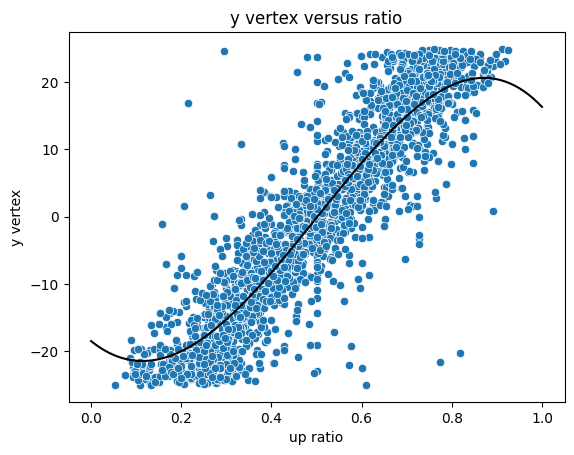

In [58]:
p = np.poly1d(np.polyfit(x=up_ratio,y=up['vy'],deg=4))
sns.scatterplot(x=up_ratio,y=up['vy'])
plt.plot(np.linspace(0,1,100),p(np.linspace(0,1,100)),c='black')
plt.xlabel('up ratio')
plt.ylabel('y vertex')
plt.title('y vertex versus ratio')

Text(0.5, 1.0, 'x vertex versus ratio')

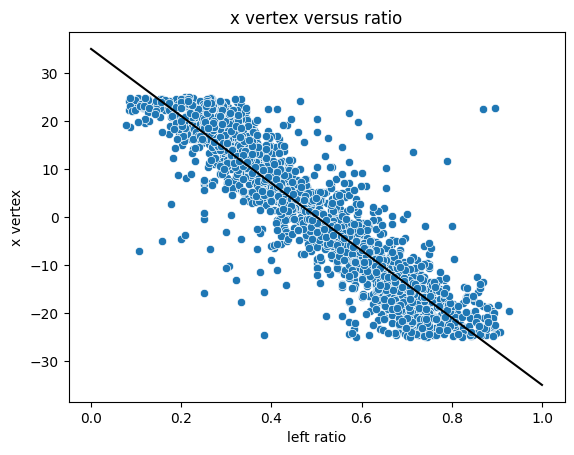

In [59]:
p = np.poly1d(np.polyfit(x=left_ratio,y=left['vx'],deg=1))
sns.scatterplot(x=left_ratio,y=up['vx'])
plt.plot(np.linspace(0,1,100),p(np.linspace(0,1,100)),c='black')
plt.xlabel('left ratio')
plt.ylabel('x vertex')
plt.title('x vertex versus ratio')

In [41]:
for i in range(15):
    p = np.poly1d(np.polyfit(x=left_ratio,y=left['vx'],deg=i))
    pred = p(left_ratio)
    print(f"Deg = {i}, sd = {np.std(pred-left['vx'])}")

Deg = 0, sd = 14.440076268570529
Deg = 1, sd = 6.125054783159876
Deg = 2, sd = 6.121914921454844
Deg = 3, sd = 5.869664537977798
Deg = 4, sd = 5.866144441976968
Deg = 5, sd = 5.8613492136028436
Deg = 6, sd = 5.861346106492781
Deg = 7, sd = 5.848462683479142
Deg = 8, sd = 5.848137187355291
Deg = 9, sd = 5.840877512157167
Deg = 10, sd = 5.840619350094698
Deg = 11, sd = 5.837944688296535
Deg = 12, sd = 5.837870296790513
Deg = 13, sd = 5.83617579683633
Deg = 14, sd = 5.83609247006332


In [42]:
for i in range(15):
    p = np.poly1d(np.polyfit(x=up_ratio,y=up['vy'],deg=i))
    pred = p(up_ratio)
    print(f"Deg = {i}, sd = {np.std(pred-up['vy'])}")

Deg = 0, sd = 14.249602620126334
Deg = 1, sd = 6.100369483923539
Deg = 2, sd = 6.0998014935256455
Deg = 3, sd = 5.899021654377924
Deg = 4, sd = 5.898932454825857
Deg = 5, sd = 5.898389097515145
Deg = 6, sd = 5.898389064574864
Deg = 7, sd = 5.878285863876252
Deg = 8, sd = 5.878285269720327
Deg = 9, sd = 5.867328420726407
Deg = 10, sd = 5.865970439829011
Deg = 11, sd = 5.86423805520656
Deg = 12, sd = 5.864234291055736
Deg = 13, sd = 5.862970962322344
Deg = 14, sd = 5.859149248691996
